# MAJIQ to PSI_pred input - Cassette Exons

In [1]:
!date
!hostname

Sat Oct 26 22:04:19 PDT 2024
c4-dev3


In [2]:
%env CONDA_PREFIX

'/c4/home/derek/miniconda3/envs/scquint_4'

In [3]:
##notebook for associating splice junctions with MAJIQ Voila output

In [4]:
# import sys
# !mamba install --yes --prefix {sys.prefix} sympy

In [5]:
import sys
import os
import operator
from collections import Counter

import numpy as np
import pandas as pd
import scipy
from sympy import Interval, Union

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import anndata as ad


from scquint.data import calculate_PSI

In [6]:
pd.set_option('display.max_columns', None)

In [7]:
## define processing functions

#https://stackoverflow.com/questions/46250830/why-function-returns-only-one-max-value-python3
def max_all(iterable, *, key):
    it = iter(iterable)
    max_values = [next(it)]
    max_key = key(max_values[0])

    for x in it:
        x_key = key(x)

        if x_key > max_key:
            max_values = [x]
            max_key = x_key
        elif x_key == max_key:
            max_values.append(x)

    return max_values

#from https://stackoverflow.com/questions/48243507/group-rows-by-overlapping-ranges

def union(data):
    """ Union of a list of intervals e.g. [(1,2),(3,4)] """
    intervals = [Interval(begin, end) for (begin, end) in data]
    u = Union(*intervals)
    return [u] if isinstance(u, Interval) \
        else list(u.args)

### get splicing and cassette exon datas 

In [8]:
output_dir='/c4/home/derek/data1/derek/data_scSLR/prenatal_brain/'

In [9]:
adata_3prime = sc.read_h5ad(output_dir+'3prime_grouped_spl_bc.h5ad')
adata_3prime.var['junc'] = (adata_3prime.var['start']-1).astype(str)+'-'+(adata_3prime.var['end']+1).astype(str)

adata_5prime = sc.read_h5ad(output_dir+'5prime_grouped_spl_bc.h5ad')
adata_5prime.var['junc'] = (adata_5prime.var['start']-1).astype(str)+'-'+(adata_5prime.var['end']+1).astype(str)

### load cassette exon annotation from MAJIQ

In [10]:
input_dir ='/c4/home/derek/data1//derek/data_scSLR/prenatal_brain/majiq/voila_modulize_out_PSI_0.01_wConstitutive/'

cass = pd.read_csv(input_dir+'cassette.tsv',sep='\t',comment='#')

/scratch/derek/ipykernel_3274021/3976852381.py:3: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  cass = pd.read_csv(input_dir+'cassette.tsv',sep='\t',comment='#')


In [11]:
cass

,module_id,gene_id,gene_name,seqid,strand,lsv_id,event_id,complex,denovo,reference_exon_coord,spliced_with,spliced_with_coord,junction_name,junction_coord,event_size,event_non_changing,event_changing,junction_changing,merged_complete_median_reads,merged_complete_median_psi,merged_complete_var_psi
0,ENSG00000088888.18_1,ENSG00000088888.18,MAVS,chr20,+,ENSG00000088888.18:s:3846799-3846903,ENSG00000088888.18_1_CE_1,True,True,3846799-3846903,C2,3857635-3857809,C1_C2,3846903-3857635,184,NaN,NaN,NaN,10,0.02482,0.000172
1,ENSG00000088888.18_1,ENSG00000088888.18,MAVS,chr20,+,ENSG00000088888.18:s:3846799-3846903,ENSG00000088888.18_1_CE_1,True,False,3846799-3846903,A,3854558-3854741,C1_A,3846903-3854558,184,NaN,NaN,NaN,791,0.97520,0.000172
2,ENSG00000088888.18_1,ENSG00000088888.18,MAVS,chr20,+,ENSG00000088888.18:t:3857635-3857809,ENSG00000088888.18_1_CE_1,True,True,3857635-3857809,C1,3846799-3846903,C2_C1,3846903-3857635,184,NaN,NaN,NaN,10,0.04305,0.000304
3,ENSG00000088888.18_1,ENSG00000088888.18,MAVS,chr20,+,ENSG00000088888.18:t:3857635-3857809,ENSG00000088888.18_1_CE_1,True,False,3857635-3857809,A,3854558-3854741,C2_A,3854741-3857635,184,NaN,NaN,NaN,384,0.95700,0.000304
4,ENSG00000088888.18_1,ENSG00000088888.18,MAVS,chr20,+,ENSG00000088888.18:s:3854558-3854741,ENSG00000088888.18_1_CE_2,True,False,3854558-3854741,C2,3861332-3861504,C1_C2,3854741-3861332,175,NaN,NaN,NaN,22,0.06898,0.001343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169507,ENSG00000154839.10_2,ENSG00000154839.10,SKA1,chr18,+,ENSG00000154839.10:t:50382129-50382226,ENSG00000154839.10_2_CE_1,False,False,50382129-50382226,A,50380126-50380250,C2_A,50380250-50382129,125,NaN,NaN,NaN,337,0.96480,0.000305
169508,ENSG00000077097.17_19,ENSG00000077097.17,TOP2B,chr3,-,ENSG00000077097.17:s:25618654-25618849,ENSG00000077097.17_19_CE_1,True,False,25618654-25618849,C2,25615431-25615586,C1_C2,25615586-25618654,92,NaN,NaN,NaN,160,0.03117,0.000087
169509,ENSG00000077097.17_19,ENSG00000077097.17,TOP2B,chr3,-,ENSG00000077097.17:s:25618654-25618849,ENSG00000077097.17_19_CE_1,True,False,25618654-25618849,A,25618418-25618509,C1_A,25618509-25618654,92,NaN,NaN,NaN,7534,0.96880,0.000086
169510,ENSG00000077097.17_19,ENSG00000077097.17,TOP2B,chr3,-,ENSG00000077097.17:t:25615431-25615586,ENSG00000077097.17_19_CE_1,True,False,25615431-25615586,C1,25618654-25618849,C2_C1,25615586-25618654,92,NaN,NaN,NaN,160,0.03676,0.000049


In [12]:
cass['var_name'] = cass['gene_name'] + '_' + cass['seqid'] + ':' + (cass.junction_coord.str.split('-',expand=True)[0].astype(int)+1).astype(str) + '-' + (cass.junction_coord.str.split('-',expand=True)[1].astype(int)-1).astype(str)

### get concoordinate junctions between MAJIQ annotation and scQuint adatas

In [13]:
#filter the MAJIQ cassette output for junctions that show up in the scquint processed 3prime and 5prime anndatas, and therefore  #require meeting certain read depth thresholds and requirements of pairing from shared donor/acceptor 

In [14]:
%%time

junc_dict = {}


for index, row in cass.iterrows():
    
    if row['junction_name'].startswith('C1'):
        
        if row['strand'] == '+':
            intron_group = row['gene_name'] + '_' +row['seqid']+'_'+ str(int(row['junction_coord'].split('-')[0])+1) +'_'+row['strand']
            junc = adata_5prime.var.loc[(adata_5prime.var['intron_group'] == intron_group) & (adata_5prime.var['end'] == int(row['junction_coord'].split('-')[1])-1)]
            
        else:
            intron_group = row['gene_name'] + '_' +row['seqid']+'_'+ str(int(row['junction_coord'].split('-')[1])-1) +'_'+row['strand']
            junc = adata_5prime.var.loc[(adata_5prime.var['intron_group'] == intron_group) & (adata_5prime.var['start'] == int(row['junction_coord'].split('-')[0])+1)]
            
        if junc.size != 0:
            junc_dict[index] = [junc.index[0], row['event_id'], row['junction_name'], row['spliced_with'], row['spliced_with_coord'], row['seqid'], row['strand'],
                                row.merged_complete_median_reads, junc.n_cells.values[0]]
            
    elif row['junction_name'].startswith('C2'):
        
        if row['strand'] == '+':
            intron_group = row['gene_name'] + '_' +row['seqid']+'_'+ str(int(row['junction_coord'].split('-')[1])-1) +'_'+row['strand']
            junc = adata_3prime.var.loc[(adata_3prime.var['intron_group'] == intron_group) & (adata_3prime.var['start'] == int(row['junction_coord'].split('-')[0])+1)]
        else:
            intron_group = row['gene_name'] + '_' +row['seqid']+'_'+ str(int(row['junction_coord'].split('-')[0])+1) +'_'+row['strand']
            junc = adata_3prime.var.loc[(adata_3prime.var['intron_group'] == intron_group) & (adata_3prime.var['end'] == int(row['junction_coord'].split('-')[1])-1)]
        
        if junc.size != 0:
            junc_dict[index] = [junc.index[0], row['event_id'], row['junction_name'], row['spliced_with'], row['spliced_with_coord'], row['seqid'], row['strand'],
                                row.merged_complete_median_reads, junc.n_cells.values[0]]

            
junc_frame = pd.DataFrame.from_dict(junc_dict).T

junc_frame.columns = ['var_name','MAJIQ_event_id','MAJIQ_event_name','MAJIQ_spliced_with','MAJIQ_spliced_with_coord',
                        'chromosome','strand','n_fragments','n_cells']



CPU times: user 2min 1s, sys: 196 ms, total: 2min 1s
Wall time: 2min 1s


In [15]:
#filtering on anndatas removes ~40% of junctions
len(junc_frame) / len(cass)

0.5835103119543159

#### remove MAJIQ events missing component junctions

In [16]:
%%time

black_list = {}

for event_id in junc_frame.MAJIQ_event_id:
    event_list = junc_frame[junc_frame.MAJIQ_event_id == event_id].MAJIQ_event_name.tolist()
    
    if sorted(event_list) != sorted(['C1_C2','C1_A','C2_A','C2_C1']):
        black_list[event_id] = event_list

CPU times: user 8min 41s, sys: 61.5 ms, total: 8min 41s
Wall time: 8min 42s


In [17]:
len(black_list.keys())

11835

In [18]:
junc_frame=junc_frame[~junc_frame.MAJIQ_event_id.isin(black_list.keys())]

In [19]:
junc_frame.MAJIQ_event_name.value_counts()

C1_C2    19195
C1_A     19195
C2_C1    19195
C2_A     19195
Name: MAJIQ_event_name, dtype: int64

In [20]:
len(junc_frame)

76780

#### double check cassette exons

In [21]:
%%time
temp_dict = {}

#for each MAJIQ event, make sure junctions C1_C2 == C2_C1
for event in junc_frame.MAJIQ_event_id.unique():
    event_juncs = junc_frame[junc_frame.MAJIQ_event_id == event]
    
    assert event_juncs[event_juncs.MAJIQ_event_name == 'C1_C2']['var_name'].values[0] == event_juncs[event_juncs.MAJIQ_event_name == 'C2_C1']['var_name'].values[0]


temp_dict = {}

#for each MAJIQ event, make sure the var_names define the cassette exon

for event in junc_frame.MAJIQ_event_id.unique():
    event_juncs = junc_frame[junc_frame.MAJIQ_event_id == event]
    
    
    if event_juncs[event_juncs.MAJIQ_event_name == 'C1_A']['strand'].values[0] == '+':
        exon_start = str(int(event_juncs[event_juncs.MAJIQ_event_name == 'C1_A']['var_name'].values[0].split(':')[1].split('-')[1])+1)
    
        exon_end =  str(int(event_juncs[event_juncs.MAJIQ_event_name == 'C2_A']['var_name'].values[0].split(':')[1].split('-')[0])-1)
    
        
    
    else:
        exon_start = str(int(event_juncs[event_juncs.MAJIQ_event_name == 'C2_A']['var_name'].values[0].split(':')[1].split('-')[1])+1)
    
        exon_end =  str(int(event_juncs[event_juncs.MAJIQ_event_name == 'C1_A']['var_name'].values[0].split(':')[1].split('-')[0])-1)

            
    assert (exon_start + '-' + exon_end) == event_juncs[event_juncs.MAJIQ_event_name == 'C1_A']['MAJIQ_spliced_with_coord'].values[0]
    
    

CPU times: user 3min 8s, sys: 39.9 ms, total: 3min 8s
Wall time: 3min 8s


In [22]:
junc_frame

,var_name,MAJIQ_event_id,MAJIQ_event_name,MAJIQ_spliced_with,MAJIQ_spliced_with_coord,chromosome,strand,n_fragments,n_cells
0,MAVS_chr20:3846904-3857634,ENSG00000088888.18_1_CE_1,C1_C2,C2,3857635-3857809,chr20,+,10,14
1,MAVS_chr20:3846904-3854557,ENSG00000088888.18_1_CE_1,C1_A,A,3854558-3854741,chr20,+,791,345
2,MAVS_chr20:3846904-3857634,ENSG00000088888.18_1_CE_1,C2_C1,C1,3846799-3846903,chr20,+,10,14
3,MAVS_chr20:3854742-3857634,ENSG00000088888.18_1_CE_1,C2_A,A,3854558-3854741,chr20,+,384,128
20,PANK2_chr20:3908279-3910576,ENSG00000125779.24_1_CE_4,C1_C2,C2,3910577-3910830,chr20,+,734,300
...,...,...,...,...,...,...,...,...,...
169503,TNPO1_chr5:72900082-72900973,ENSG00000083312.19_3_CE_2,C2_A,A,72900045-72900081,chr5,+,4814,1604
169508,TOP2B_chr3:25615587-25618653,ENSG00000077097.17_19_CE_1,C1_C2,C2,25615431-25615586,chr3,-,160,41
169509,TOP2B_chr3:25618510-25618653,ENSG00000077097.17_19_CE_1,C1_A,A,25618418-25618509,chr3,-,7534,1768
169510,TOP2B_chr3:25615587-25618653,ENSG00000077097.17_19_CE_1,C2_C1,C1,25618654-25618849,chr3,-,160,41


### define cassette exon and flanking exon coordinates for each event

In [23]:
%%time
junc_dict = {}

for name, group in junc_frame.groupby('MAJIQ_event_id'):
    
    
    CE = group[group['MAJIQ_spliced_with'] == 'A'].MAJIQ_spliced_with_coord.unique()[0]
    
    junc_dict[name] = CE

junc_frame['exon'] = junc_frame.MAJIQ_event_id.map(junc_dict)

CPU times: user 6.62 s, sys: 11 ms, total: 6.64 s
Wall time: 6.69 s


In [24]:
%%time
upstream_exon_dict = {}
downstream_exon_dict = {}


for name, group in junc_frame.groupby('MAJIQ_event_id'):
    strand = group['strand']
        
    #upstream = C1, downstream = C2
    
    flanking_exons = group[group['MAJIQ_event_name'] == 'C1_C2']['var_name'].str.split(':',expand=True)[1].values[0]
    
    upstream_exon_dict[name] = flanking_exons.split('-')[0]
    
    downstream_exon_dict[name] = flanking_exons.split('-')[1]

    
    
junc_frame['upstream_exon'] = junc_frame.MAJIQ_event_id.map(upstream_exon_dict)

junc_frame['downstream_exon'] = junc_frame.MAJIQ_event_id.map(downstream_exon_dict)

    

CPU times: user 11.8 s, sys: 11.7 ms, total: 11.8 s
Wall time: 11.9 s


In [25]:
junc_frame['gene_name'] = junc_frame.var_name.str.split('_',expand=True)[0]

junc_frame['exon_start'] = junc_frame.exon.str.split('-').str[0]
junc_frame['exon_end'] = junc_frame.exon.str.split('-').str[1]

junc_frame['exon_length'] = pd.DataFrame(junc_frame['exon_end'].astype(int) - junc_frame['exon_start'].astype(int))

In [26]:
junc_frame.shape


(76780, 16)

In [27]:
junc_frame = junc_frame[junc_frame.exon_length > 0]


In [28]:
len(junc_frame) / 4

19168.0

In [29]:
#junc_frame.to_csv('/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/'+'cassette_junction_frame.csv')

### associate the annotated junctions with the splicing count matrix

In [30]:
input_dir = '/nowakowskilab/data1/derek/scSLR/notebooks/fig3/'
adata = sc.read_h5ad(input_dir+'singlets_spl_.h5ad') #includes singlet junctions, not just paired


In [31]:
var = adata.var.copy()

var['var_name'] = var.index

adata.var['var_name'] = var.index

In [32]:
%%time

var_dict = {}

# for each intron group in adata
for intron_group in var.intron_group.unique():
   
    #get the introns associated with the intron group
    subgroup = var[var.intron_group == intron_group]
    
    
    #get the set of introns, to take into account junctions listed multiple times
    var_set = set(subgroup.var_name)
    
    

    #get the gene name associated with the intron group
    gene = subgroup.gene_name.iloc[0]
    
    #get the MAJIQ junctions associated with the gene
    junc_frame_gene = junc_frame[junc_frame.gene_name == gene]
    
    #get the set of MAJIQ junctions
    junc_sets_gene = junc_frame_gene.groupby('MAJIQ_event_id')['var_name'].aggregate(lambda x: set(x))
    
    
    #get set-intersections betweeen the MAJIQ junctions and the sig-diff var_set
    junc_dict = {}
    
    
    for event_id, junc_set in junc_sets_gene.items():
        
        #print(event_id)
        #print(junc_set)
        count = len(var_set.intersection(junc_set))
        
        #need to share at least 2 junctions between the MAJIQ event and the junctions in the intron_group
        if (count > 1): 
            junc_dict[event_id] = count
        
        else:
            pass

    
    if bool(junc_dict):
        var_dict[intron_group] = max_all(junc_dict.keys(), key=operator.itemgetter(1))
    else:
        var_dict[intron_group] = []

CPU times: user 3min 21s, sys: 138 ms, total: 3min 22s
Wall time: 3min 22s


In [33]:
var.intron_group[var.intron_group == 'UBE2J2_chr1_1263387_-']

UBE2J2_chr1:1263387-1264782    UBE2J2_chr1_1263387_-
UBE2J2_chr1:1263387-1267732    UBE2J2_chr1_1263387_-
UBE2J2_chr1:1263387-1267861    UBE2J2_chr1_1263387_-
UBE2J2_chr1:1263387-1273665    UBE2J2_chr1_1263387_-
Name: intron_group, dtype: category
Categories (42577, object): ['A1BG-AS1_chr19_58347845_+', 'AAAS_chr12_53307714_-', 'AAAS_chr12_53308051_-', 'AAAS_chr12_53308959_-', ..., 'ZYX_chr7_143381410_+', 'ZYX_chr7_143388218_+', 'ZYX_chr7_143388488_+', 'ZZEF1_chr17_4070925_-']

In [34]:
#remove empty items from var_dict
var_dict_ = {key:val for key, val in var_dict.items() if val != []}


var_df = pd.DataFrame([var_dict_]).T
var_df.columns = ['MAJIQ_IDS']



In [35]:
var_df

,MAJIQ_IDS
LINC01128_chr1_851926_+,[ENSG00000228794.12_2_CE_3]
HES4_chr1_999614_-,[ENSG00000188290.11_1_CE_1]
UBE2J2_chr1_1263387_-,"[ENSG00000160087.21_1_CE_3, ENSG00000160087.21..."
INTS11_chr1_1312369_-,[ENSG00000127054.22_3_CE_1]
DVL1_chr1_1336516_-,[ENSG00000107404.21_12_CE_1]
...,...
ARMCX6_chrX_101617884_-,[ENSG00000198960.11_1_CE_3]
TCEAL4_chrX_103585625_+,"[ENSG00000133142.19_1_CE_4, ENSG00000133142.19..."
UPF3B_chrX_119843190_-,[ENSG00000125351.14_1_CE_1]
UPF3B_chrX_119845197_-,[ENSG00000125351.14_1_CE_2]


In [36]:
var_df_ = pd.DataFrame(var_df.MAJIQ_IDS.explode())


In [37]:
# var_df_.to_csv('cassette_SJ.tsv', sep='\t')
               

In [38]:
junc_frame.exon_length

0         183
1         183
2         183
3         183
20        233
         ... 
169503     36
169508     91
169509     91
169510     91
169511     91
Name: exon_length, Length: 76672, dtype: int64

/scratch/derek/ipykernel_3274021/4280350618.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(junc_frame[junc_frame.exon_length <= 30].exon_length, kde=False, bins=30,


<Axes: xlabel='exon_length'>

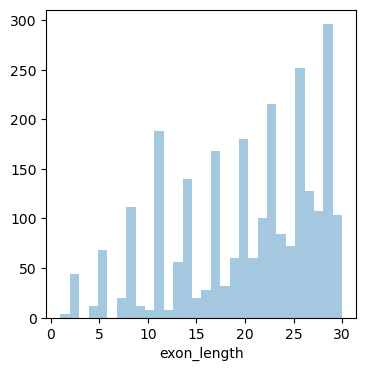

In [39]:
fig, ax = plt.subplots(figsize=(4,4)) 

sns.distplot(junc_frame[junc_frame.exon_length <= 30].exon_length, kde=False, bins=30, 
            ax=ax)

In [40]:
%%time
# from each group of introns, select the var_name associated with cassette exons (C2_A or C1_A depending on grouping polarity)

junc_dict = {}

# for each intron group
for intron_group, majiq_id in var_df_.iterrows():
    
    #get the introns belonging to that intron group
    var_intron_group = var[var.intron_group == intron_group]
    
    #get the MAJIQ event based on MAJIQ event id
    event = junc_frame[junc_frame.MAJIQ_event_id == majiq_id['MAJIQ_IDS']]
    
    # if grouping is by threeprime
    if (var_intron_group.grouping.iloc[0] == 'three_prime'):
        
        #cassette inclusion event is C2_A
        event_A = event[event.MAJIQ_event_name == 'C2_A']
        
        var_name = var_intron_group[var_intron_group.var_name == event_A.var_name.values[0]]
        
        junc_dict[var_name['var_name'].values[0]] = majiq_id.values[0]
        
    elif (var_intron_group.grouping.iloc[0] == 'five_prime'):       
        event_A = event[event.MAJIQ_event_name == 'C1_A']
        
        var_name = var_intron_group[var_intron_group.var_name == event_A.var_name.values[0]]
        
        junc_dict[var_name['var_name'].values[0]] = majiq_id.values[0]


CPU times: user 1min 34s, sys: 42.9 ms, total: 1min 34s
Wall time: 1min 35s


In [41]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
len(junc_dict)

In [ ]:
# junc_frame.to_csv('cassette_SJ.tsv', sep='\t')

In [ ]:
junc_frame

In [42]:
pwd

'/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/deep_splicing/transfer_learning'

# get MAJIQ motif analysis exons 

In [43]:
# current workflow uses significant differentially spliced exons at delta PSI of 0.1, utlizing the file 
# '/nowakowskilab/data1/derek/scSLR/notebooks/fig3/sig_dif_0.1.csv'

In [44]:
# get scquint DS results between celltypes
sig_dif = pd.read_csv('/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/dif_RG_EN.csv',index_col=0)

In [45]:
sig_dif.test_group.value_counts()

EN    45485
RG    45485
Name: test_group, dtype: int64

In [46]:
sig_dif_intron_groups = pd.read_csv('/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/dif_intron_groups_RG_EN.csv',index_col=0)

In [47]:
sig_dif_intron_groups

,p_value,ll_null,ll,n_classes,gene_id,gene_name,max_abs_delta_psi,max_abs_lfc_psi,ranking,p_value_adj,test_group,name
0,0.000000e+00,-2590.125947,-1607.275283,4,ENSG00000185942,NKAIN3,7.239330e-01,3.275057,0,0.000000e+00,EN,NKAIN3_chr8_62965353_+
1,0.000000e+00,-12173.814438,-11457.575189,2,ENSG00000245910,SNHG6,2.565948e-01,1.318461,1,0.000000e+00,EN,SNHG6_chr8_66922115_-
2,0.000000e+00,-1285.864723,-553.625026,2,ENSG00000047932,GOPC,6.763550e-01,5.672242,2,0.000000e+00,EN,GOPC_chr6_117578899_-
3,1.206608e-236,-10799.703811,-10260.200156,2,ENSG00000092841,MYL6,1.837367e-01,1.321217,3,5.746167e-233,EN,MYL6_chr12_56161386_+
4,2.979914e-200,-2169.850458,-1714.059809,2,ENSG00000046653,GPM6B,3.891799e-01,3.049499,4,1.135288e-196,EN,GPM6B_chrX_13776237_-
...,...,...,...,...,...,...,...,...,...,...,...,...
38093,1.000000e+00,-107.106151,-107.106151,2,ENSG00000169255,B3GALNT1,4.973996e-06,0.000115,19044,1.000000e+00,RG,B3GALNT1_chr3_161104318_-
38094,1.000000e+00,-70.834484,-70.834485,2,ENSG00000186522,SEPTIN10,1.432516e-05,0.000207,19045,1.000000e+00,RG,SEPTIN10_chr2_109613797_-
38095,1.000000e+00,-108.034553,-108.034553,2,ENSG00000126226,PCID2,1.385728e-07,0.000006,19046,1.000000e+00,RG,PCID2_chr13_113178288_-
38096,1.000000e+00,-40.032194,-40.032194,2,ENSG00000247950,SEC24B-AS1,2.783323e-07,0.000002,19047,1.000000e+00,RG,SEC24B-AS1_chr4_109431747_-


In [48]:
sig_dif['MAJIQ_event_id'] = sig_dif.name.map(junc_dict)

In [49]:
sig_dif

,chromosome,start,end,strand,intron_motif,n_cells,gene_id_start,gene_id_end,n_genes,gene_id,gene_name,size,intron_group,intron_group_size,n_genes_per_intron_group,grouping,psi_a,psi_b,delta_psi,lfc_psi,abs_delta_psi,abs_lfc_psi,test_group,name,MAJIQ_event_id
0,chr1,944801,945041,-,2,77,ENSG00000188976,ENSG00000188976,1,ENSG00000188976,NOC2L,240,NOC2L_chr1_944801_-,2,1,three_prime,0.227723,0.212122,0.015601,0.102388,0.015601,0.102388,EN,NOC2L_chr1:944801-945041,NaN
1,chr1,944801,945056,-,2,244,ENSG00000188976,ENSG00000188976,1,ENSG00000188976,NOC2L,255,NOC2L_chr1_944801_-,2,1,three_prime,0.772277,0.787878,-0.015601,-0.028855,0.015601,0.028855,EN,NOC2L_chr1:944801-945056,NaN
2,chr1,999433,999525,-,2,1790,ENSG00000188290,ENSG00000188290,1,ENSG00000188290,HES4,92,HES4_chr1_999433_-,2,1,three_prime,0.965646,0.975540,-0.009894,-0.014707,0.009894,0.014707,EN,HES4_chr1:999433-999525,NaN
3,chr1,999433,999532,-,2,63,ENSG00000188290,NaN,1,ENSG00000188290,HES4,99,HES4_chr1_999433_-,2,1,three_prime,0.034354,0.024460,0.009894,0.490074,0.009894,0.490074,EN,HES4_chr1:999433-999532,NaN
4,chr1,999614,999691,-,2,724,ENSG00000188290,ENSG00000188290,1,ENSG00000188290,HES4,77,HES4_chr1_999614_-,2,1,three_prime,0.781873,0.759705,0.022168,0.041494,0.022168,0.041494,EN,HES4_chr1:999614-999691,ENSG00000188290.11_1_CE_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90965,chrX,119841779,119843190,-,2,3102,ENSG00000125351,ENSG00000125351,1,ENSG00000125351,UPF3B,1411,UPF3B_chrX_119843190_-,2,1,five_prime,0.972346,0.971372,0.000974,0.001446,0.000974,0.001446,RG,UPF3B_chrX:119841779-119843190,ENSG00000125351.14_1_CE_1
90966,chrX,129447234,129448332,-,2,460,ENSG00000102038,ENSG00000102038,1,ENSG00000102038,SMARCA1,1098,SMARCA1_chrX_129448332_-,2,1,five_prime,0.764646,0.822617,-0.057971,-0.105429,0.057971,0.105429,RG,SMARCA1_chrX:129447234-129448332,NaN
90967,chrX,129447302,129448332,-,2,120,ENSG00000102038,ENSG00000102038,1,ENSG00000102038,SMARCA1,1030,SMARCA1_chrX_129448332_-,2,1,five_prime,0.235354,0.177383,0.057971,0.407964,0.057971,0.407964,RG,SMARCA1_chrX:129447302-129448332,NaN
90968,chrX,138708929,139204058,-,2,223,ENSG00000129682,ENSG00000129682,1,ENSG00000129682,FGF13,495129,FGF13_chrX_139204058_-,2,1,five_prime,0.178572,0.271627,-0.093056,-0.605125,0.093056,0.605125,RG,FGF13_chrX:138708929-139204058,NaN


In [50]:
sig_dif = sig_dif[~sig_dif.MAJIQ_event_id.isna()]

In [51]:
sig_dif

,chromosome,start,end,strand,intron_motif,n_cells,gene_id_start,gene_id_end,n_genes,gene_id,gene_name,size,intron_group,intron_group_size,n_genes_per_intron_group,grouping,psi_a,psi_b,delta_psi,lfc_psi,abs_delta_psi,abs_lfc_psi,test_group,name,MAJIQ_event_id
4,chr1,999614,999691,-,2,724,ENSG00000188290,ENSG00000188290,1,ENSG00000188290,HES4,77,HES4_chr1_999614_-,2,1,three_prime,0.781873,7.597054e-01,0.022168,0.041494,0.022168,0.041494,EN,HES4_chr1:999614-999691,ENSG00000188290.11_1_CE_1
8,chr1,1263387,1264782,-,2,15,ENSG00000160087,ENSG00000160087,1,ENSG00000160087,UBE2J2,1395,UBE2J2_chr1_1263387_-,4,1,three_prime,0.033113,2.984164e-19,0.033113,24.980873,0.033113,24.980873,EN,UBE2J2_chr1:1263387-1264782,ENSG00000160087.21_1_CE_3
9,chr1,1263387,1267732,-,2,18,ENSG00000160087,ENSG00000160087,1,ENSG00000160087,UBE2J2,4345,UBE2J2_chr1_1263387_-,4,1,three_prime,0.039735,4.997765e-20,0.039735,25.243907,0.039735,25.243907,EN,UBE2J2_chr1:1263387-1267732,ENSG00000160087.21_1_CE_4
10,chr1,1263387,1267861,-,2,442,ENSG00000160087,ENSG00000160087,1,ENSG00000160087,UBE2J2,4474,UBE2J2_chr1_1263387_-,4,1,three_prime,0.857616,8.852461e-01,-0.027630,-0.045747,0.027630,0.045747,EN,UBE2J2_chr1:1263387-1267861,ENSG00000160087.21_1_CE_5
12,chr1,1312369,1312439,-,2,412,ENSG00000127054,ENSG00000127054,1,ENSG00000127054,INTS11,70,INTS11_chr1_1312369_-,2,1,three_prime,0.965958,9.531250e-01,0.012833,0.019295,0.012833,0.019295,EN,INTS11_chr1:1312369-1312439,ENSG00000127054.22_3_CE_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90949,chr9,133356321,133356399,-,2,1196,ENSG00000148290,ENSG00000148290,1,ENSG00000148290,SURF1,78,SURF1_chr9_133356399_-,3,1,five_prime,0.931204,9.075911e-01,0.023613,0.037055,0.023613,0.037055,RG,SURF1_chr9:133356321-133356399,ENSG00000148290.10_1_CE_2
90953,chrX,23833613,23840312,-,2,1650,ENSG00000184831,ENSG00000184831,1,ENSG00000184831,APOO,6699,APOO_chrX_23840312_-,2,1,five_prime,0.541744,6.003338e-01,-0.058590,-0.148154,0.058590,0.148154,RG,APOO_chrX:23833613-23840312,ENSG00000184831.14_3_CE_1
90954,chrX,73944466,73944583,+,1,1925,ENSG00000225470,ENSG00000225470,1,ENSG00000225470,JPX,117,JPX_chrX_73944466_+,2,1,five_prime,0.996753,9.724139e-01,0.024339,0.035666,0.024339,0.035666,RG,JPX_chrX:73944466-73944583,ENSG00000225470.9_1_CE_2
90965,chrX,119841779,119843190,-,2,3102,ENSG00000125351,ENSG00000125351,1,ENSG00000125351,UPF3B,1411,UPF3B_chrX_119843190_-,2,1,five_prime,0.972346,9.713725e-01,0.000974,0.001446,0.000974,0.001446,RG,UPF3B_chrX:119841779-119843190,ENSG00000125351.14_1_CE_1


In [52]:
sig_dif['exon'] = sig_dif['MAJIQ_event_id'].map(dict(zip(junc_frame['MAJIQ_event_id'],junc_frame['exon'])))

/scratch/derek/ipykernel_3274021/507649069.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_dif['exon'] = sig_dif['MAJIQ_event_id'].map(dict(zip(junc_frame['MAJIQ_event_id'],junc_frame['exon'])))


In [53]:
sig_dif_intron_groups

,p_value,ll_null,ll,n_classes,gene_id,gene_name,max_abs_delta_psi,max_abs_lfc_psi,ranking,p_value_adj,test_group,name
0,0.000000e+00,-2590.125947,-1607.275283,4,ENSG00000185942,NKAIN3,7.239330e-01,3.275057,0,0.000000e+00,EN,NKAIN3_chr8_62965353_+
1,0.000000e+00,-12173.814438,-11457.575189,2,ENSG00000245910,SNHG6,2.565948e-01,1.318461,1,0.000000e+00,EN,SNHG6_chr8_66922115_-
2,0.000000e+00,-1285.864723,-553.625026,2,ENSG00000047932,GOPC,6.763550e-01,5.672242,2,0.000000e+00,EN,GOPC_chr6_117578899_-
3,1.206608e-236,-10799.703811,-10260.200156,2,ENSG00000092841,MYL6,1.837367e-01,1.321217,3,5.746167e-233,EN,MYL6_chr12_56161386_+
4,2.979914e-200,-2169.850458,-1714.059809,2,ENSG00000046653,GPM6B,3.891799e-01,3.049499,4,1.135288e-196,EN,GPM6B_chrX_13776237_-
...,...,...,...,...,...,...,...,...,...,...,...,...
38093,1.000000e+00,-107.106151,-107.106151,2,ENSG00000169255,B3GALNT1,4.973996e-06,0.000115,19044,1.000000e+00,RG,B3GALNT1_chr3_161104318_-
38094,1.000000e+00,-70.834484,-70.834485,2,ENSG00000186522,SEPTIN10,1.432516e-05,0.000207,19045,1.000000e+00,RG,SEPTIN10_chr2_109613797_-
38095,1.000000e+00,-108.034553,-108.034553,2,ENSG00000126226,PCID2,1.385728e-07,0.000006,19046,1.000000e+00,RG,PCID2_chr13_113178288_-
38096,1.000000e+00,-40.032194,-40.032194,2,ENSG00000247950,SEC24B-AS1,2.783323e-07,0.000002,19047,1.000000e+00,RG,SEC24B-AS1_chr4_109431747_-


In [54]:
sig_dif['pval'] = sig_dif['intron_group'].map(dict(zip(sig_dif_intron_groups['name'],sig_dif_intron_groups['p_value_adj'])))

/scratch/derek/ipykernel_3274021/1067513121.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_dif['pval'] = sig_dif['intron_group'].map(dict(zip(sig_dif_intron_groups['name'],sig_dif_intron_groups['p_value_adj'])))


In [55]:
sig_dif_EN = sig_dif[sig_dif.test_group == 'EN']

In [56]:
# sig_dif_EN['include'] = ((sig_dif_EN['pval'] <= 0.05) & (sig_dif_EN.abs_delta_psi >= 0.1)).astype(str)

/scratch/derek/ipykernel_3274021/616062283.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_dif_EN['include'] = ((sig_dif_EN['pval'] <= 0.05) & (sig_dif_EN.abs_delta_psi >= 0.1)).astype(str)


In [ ]:
sig_dif_EN

In [95]:
conditions = [
    ((sig_dif_EN['pval'] <= 0.05) & (sig_dif_EN.delta_psi >= 0.1)),
    ((sig_dif_EN['pval'] <= 0.05) & (sig_dif_EN.delta_psi <= -0.1)),
    ((sig_dif_EN['pval'] > 0.05) | (sig_dif_EN.abs_delta_psi < 0.1))
]

values = ['neuron', 'glia', 'unsig']

sig_dif_EN['include'] = np.select(conditions, values)


In [96]:
sig_dif_EN = sig_dif_EN.sort_values(by='include')

In [58]:
sig_dif_EN

,chromosome,start,end,strand,intron_motif,n_cells,gene_id_start,gene_id_end,n_genes,gene_id,gene_name,size,intron_group,intron_group_size,n_genes_per_intron_group,grouping,psi_a,psi_b,delta_psi,lfc_psi,abs_delta_psi,abs_lfc_psi,test_group,name,MAJIQ_event_id,exon,pval,include
4,chr1,999614,999691,-,2,724,ENSG00000188290,ENSG00000188290,1,ENSG00000188290,HES4,77,HES4_chr1_999614_-,2,1,three_prime,0.781873,0.759705,0.022168,0.041494,0.022168,0.041494,EN,HES4_chr1:999614-999691,ENSG00000188290.11_1_CE_1,999692-999787,7.761442e-01,False
30866,chr16,53222756,53223449,+,1,288,ENSG00000177200,ENSG00000177200,1,ENSG00000177200,CHD9,693,CHD9_chr16_53222756_+,3,1,five_prime,0.058458,0.079626,-0.021168,-0.445848,0.021168,0.445848,EN,CHD9_chr16:53222756-53223449,ENSG00000177200.18_1_CE_13,53223450-53223507,2.956613e-01,False
30889,chr16,56625880,56626465,+,1,521,ENSG00000169715,ENSG00000169715,1,ENSG00000169715,MT1E,585,MT1E_chr16_56625880_+,2,1,five_prime,0.954833,0.965289,-0.010456,-0.015712,0.010456,0.015712,EN,MT1E_chr16:56625880-56626465,ENSG00000169715.15_1_CE_1,56626466-56626531,8.214110e-01,False
30891,chr16,56682569,56683164,+,1,926,ENSG00000187193,ENSG00000187193,1,ENSG00000187193,MT1X,595,MT1X_chr16_56682569_+,2,1,five_prime,0.963229,0.994052,-0.030823,-0.045443,0.030823,0.045443,EN,MT1X_chr16:56682569-56683164,ENSG00000187193.9_1_CE_1,56683165-56683230,3.225908e-02,False
30898,chr16,56935313,56935403,+,1,81,ENSG00000051108,ENSG00000051108,1,ENSG00000051108,HERPUD1,90,HERPUD1_chr16_56935313_+,3,1,five_prime,0.065746,0.103466,-0.037720,-0.654182,0.037720,0.654182,EN,HERPUD1_chr16:56935313-56935403,ENSG00000051108.15_1_CE_3,56935404-56935475,4.064704e-02,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20042,chr8,62918514,62965353,+,1,3354,ENSG00000185942,ENSG00000185942,1,ENSG00000185942,NKAIN3,46839,NKAIN3_chr8_62965353_+,4,1,three_prime,0.892739,0.181934,0.710805,2.294821,0.710805,2.294821,EN,NKAIN3_chr8:62918514-62965353,ENSG00000185942.13_1_CE_5,62918453-62918513,0.000000e+00,True
15170,chr3,181715293,181739568,+,1,853,ENSG00000242808,ENSG00000242808,1,ENSG00000242808,SOX2-OT,24275,SOX2-OT_chr3_181739568_+,3,1,three_prime,0.657379,0.516045,0.141333,0.349226,0.141333,0.349226,EN,SOX2-OT_chr3:181715293-181739568,ENSG00000242808.12_1_CE_28,181715185-181715292,2.248355e-02,True
20039,chr8,62953973,62965353,+,1,1690,ENSG00000185942,ENSG00000185942,1,ENSG00000185942,NKAIN3,11380,NKAIN3_chr8_62965353_+,4,1,three_prime,0.083399,0.807332,-0.723933,-3.275057,0.723933,3.275057,EN,NKAIN3_chr8:62953973-62965353,ENSG00000185942.13_1_CE_8,62953902-62953972,0.000000e+00,True
36742,chr3,342083,342983,+,1,473,ENSG00000134121,ENSG00000134121,1,ENSG00000134121,CHL1,900,CHL1_chr3_342083_+,2,1,five_prime,0.089753,0.612423,-0.522670,-2.770501,0.522670,2.770501,EN,CHL1_chr3:342083-342983,ENSG00000134121.10_1_CE_5,342984-343031,4.762374e-58,True


In [59]:
sig_dif_EN['delta_psi'].reset_index(drop=True)

0        0.022168
1       -0.021168
2       -0.010456
3       -0.030823
4       -0.037720
           ...   
11788    0.710805
11789    0.141333
11790   -0.723933
11791   -0.522670
11792   -0.162622
Name: delta_psi, Length: 11793, dtype: float64

/scratch/derek/ipykernel_3274021/1654204275.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sig_dif_EN['delta_psi'].reset_index(drop=True),


<Axes: xlabel='delta_psi'>

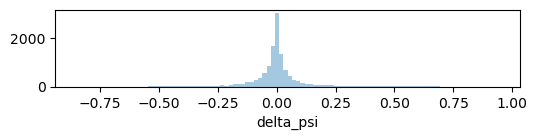

In [79]:
fig, ax = plt.subplots(1,1,figsize=(6,1))

sns.distplot(sig_dif_EN['delta_psi'].reset_index(drop=True),
             hist=True,
             kde=False,
             bins=100,
             ax=ax
            )

/c4/home/derek/miniconda3/envs/scquint_4/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/scratch/derek/ipykernel_3274021/576526433.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sig_dif_EN['delta_psi'].reset_index(drop=True),


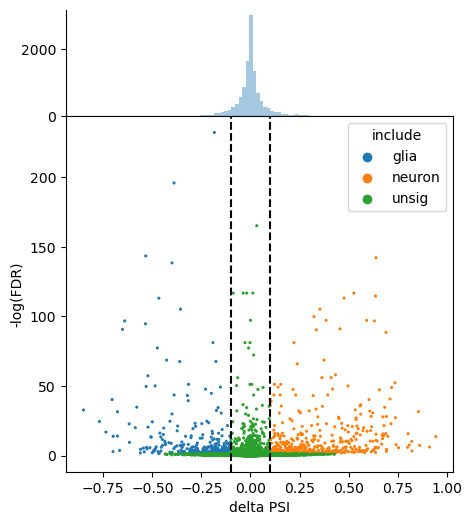

In [110]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(5,6), gridspec_kw={'height_ratios': [1.5, 5]})

fig.subplots_adjust(wspace=0, hspace=0)

sns.scatterplot(x = sig_dif_EN['delta_psi'],
                y= -np.log10(sig_dif_EN['pval']),
                s=5,
                linewidth=0,
                hue=sig_dif_EN['include'],
                ax=ax2
               )

ax2.axvline(x=-0.1, color='black', linestyle='--')

ax2.axvline(x=0.1, color='black', linestyle='--')

ax2.set(ylabel='-log(FDR)', xlabel='delta PSI')




sns.distplot(sig_dif_EN['delta_psi'].reset_index(drop=True),
             kde=False,
             hist=True,
             bins=100,
             ax=ax1
            )

ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax1.spines['top'].set_visible(False)


ax1.set_xticks([], minor=False)

fig.savefig('./included_exons.pdf')




In [ ]:
sig_dif_EN = sig_dif[sig_dif['test_group'] == 'EN']

# sig_dif_EN = sig_dif_EN[sig_dif_EN['abs_delta_psi'] > 0.1]

sig_dif_EN['MAJIQ_event_id'] = sig_dif_EN.name.map(junc_dict)

sig_dif_EN = sig_dif_EN[~sig_dif_EN.MAJIQ_event_id.isna()]

sig_dif_EN['exon'] = sig_dif_EN['MAJIQ_event_id'].map(dict(zip(junc_frame['MAJIQ_event_id'],junc_frame['exon'])))

In [ ]:
# sig_dif_EN_ = sig_dif_EN.name.map(junc_dict)

# sig_dif_EN_ = sig_dif_EN_[~sig_dif_EN_.isna()]

In [ ]:
sig_dif_EN.shape

In [ ]:
sig_dif_EN[['exon_start','exon_end']] = sig_dif_EN['exon'].str.split('-',expand=True)

sig_dif_EN['model_input'] = sig_dif_EN['chromosome']+'_'+sig_dif_EN['exon_start']+'_'+sig_dif_EN['exon_end']+'_'+sig_dif_EN['gene_id']+'_'+sig_dif_EN['strand']

In [ ]:
sig_dif_RG = sig_dif[sig_dif['test_group'] == 'RG']

sig_dif_RG = sig_dif_RG[sig_dif_RG['abs_delta_psi'] > 0.1]

sig_dif_RG['MAJIQ_event_id'] = sig_dif_RG.name.map(junc_dict)

sig_dif_RG = sig_dif_RG[~sig_dif_RG.MAJIQ_event_id.isna()]

sig_dif_RG['exon'] = sig_dif_RG['MAJIQ_event_id'].map(dict(zip(junc_frame['MAJIQ_event_id'],junc_frame['exon'])))

In [ ]:
# sig_dif_RG_ = sig_dif_RG.name.map(junc_dict)

# sig_dif_RG_ = sig_dif_RG_[~sig_dif_RG_.isna()]

In [ ]:
sig_dif_RG.shape

In [ ]:
sig_dif_RG[['exon_start','exon_end']] = sig_dif_RG['exon'].str.split('-',expand=True)

sig_dif_RG['model_input'] = sig_dif_RG['chromosome']+'_'+sig_dif_RG['exon_start']+'_'+sig_dif_RG['exon_end']+'_'+sig_dif_RG['gene_id']+'_'+sig_dif_RG['strand']

In [ ]:
# sig_dif_RG.to_csv('sig_dif_RG_table_0.1_.csv')
# sig_dif_EN.to_csv('sig_dif_EN_table_0.1_.csv')

In [ ]:
sig_dif_EN.head(1)

In [ ]:
sig_dif_RG.head(1)

In [ ]:
break

## generate exon table with lower thresholds

In [ ]:
# get scquint DS results between celltypes
sig_dif = pd.read_csv('/nowakowskilab/data1/derek/scSLR/notebooks/fig3/sig_dif_RG_EN_0.05.csv',index_col=0)

In [ ]:
sig_dif_EN = sig_dif[sig_dif['test_group'] == 'EN']

sig_dif_EN = sig_dif_EN[sig_dif_EN['abs_delta_psi'] > 0.05]

sig_dif_EN['MAJIQ_event_id'] = sig_dif_EN.name.map(junc_dict)

sig_dif_EN = sig_dif_EN[~sig_dif_EN.MAJIQ_event_id.isna()]

sig_dif_EN['exon'] = sig_dif_EN['MAJIQ_event_id'].map(dict(zip(junc_frame['MAJIQ_event_id'],junc_frame['exon'])))

In [ ]:
sig_dif_EN.shape

In [ ]:
sig_dif_EN[['exon_start','exon_end']] = sig_dif_EN['exon'].str.split('-',expand=True)

sig_dif_EN['model_input'] = sig_dif_EN['chromosome']+'_'+sig_dif_EN['exon_start']+'_'+sig_dif_EN['exon_end']+'_'+sig_dif_EN['gene_id']+'_'+sig_dif_EN['strand']

In [ ]:
sig_dif_RG = sig_dif[sig_dif['test_group'] == 'RG']

sig_dif_RG = sig_dif_RG[sig_dif_RG['abs_delta_psi'] > 0.05]

sig_dif_RG['MAJIQ_event_id'] = sig_dif_RG.name.map(junc_dict)

sig_dif_RG = sig_dif_RG[~sig_dif_RG.MAJIQ_event_id.isna()]

sig_dif_RG['exon'] = sig_dif_RG['MAJIQ_event_id'].map(dict(zip(junc_frame['MAJIQ_event_id'],junc_frame['exon'])))

In [ ]:
sig_dif_RG.shape

In [ ]:
sig_dif_RG[['exon_start','exon_end']] = sig_dif_RG['exon'].str.split('-',expand=True)

sig_dif_RG['model_input'] = sig_dif_RG['chromosome']+'_'+sig_dif_RG['exon_start']+'_'+sig_dif_RG['exon_end']+'_'+sig_dif_RG['gene_id']+'_'+sig_dif_RG['strand']

In [ ]:
# sig_dif_RG.to_csv('sig_dif_RG_table_0.05_.csv')
# sig_dif_EN.to_csv('sig_dif_EN_table_0.05_.csv')

In [ ]:
# get scquint DS results between celltypes
unsig_dif = pd.read_csv('/nowakowskilab/data1/derek/scSLR/notebooks/fig3/unsig_dif_RG_EN.csv',index_col=0)

In [ ]:
unsig_dif_EN = unsig_dif[unsig_dif['test_group'] == 'EN']

# sig_dif_EN = sig_dif_EN[sig_dif_EN['delta_psi'] > 0.1]

In [ ]:
unsig_dif_EN['MAJIQ_event_id'] = unsig_dif_EN.name.map(junc_dict)

unsig_dif_EN = unsig_dif_EN[~unsig_dif_EN.MAJIQ_event_id.isna()]

unsig_dif_EN['exon'] = unsig_dif_EN['MAJIQ_event_id'].map(dict(zip(junc_frame['MAJIQ_event_id'],junc_frame['exon'])))

In [ ]:
unsig_dif_EN[['exon_start','exon_end']] = unsig_dif_EN['exon'].str.split('-',expand=True)

unsig_dif_EN['model_input'] = unsig_dif_EN['chromosome']+'_'+unsig_dif_EN['exon_start']+'_'+unsig_dif_EN['exon_end']+'_'+unsig_dif_EN['gene_id']+'_'+unsig_dif_EN['strand']

In [ ]:
unsig_dif_RG = unsig_dif[unsig_dif['test_group'] == 'RG']

# sig_dif_RG = sig_dif_RG[sig_dif_RG['delta_psi'] > 0.1]

In [ ]:
unsig_dif_RG['MAJIQ_event_id'] = unsig_dif_RG.name.map(junc_dict)

unsig_dif_RG = unsig_dif_RG[~unsig_dif_RG.MAJIQ_event_id.isna()]

unsig_dif_RG['exon'] = unsig_dif_RG['MAJIQ_event_id'].map(dict(zip(junc_frame['MAJIQ_event_id'],junc_frame['exon'])))

In [ ]:
unsig_dif_RG[['exon_start','exon_end']] = unsig_dif_RG['exon'].str.split('-',expand=True)

unsig_dif_RG['model_input'] = unsig_dif_RG['chromosome']+'_'+unsig_dif_RG['exon_start']+'_'+unsig_dif_RG['exon_end']+'_'+unsig_dif_RG['gene_id']+'_'+unsig_dif_RG['strand']

In [ ]:
# sig_dif_EN_.to_csv('/nowakowskilab/data1/derek/scSLR/notebooks/fig4/sig_dif_EN_0.2.txt', header=None, index=False)

# sig_dif_RG_.to_csv('/nowakowskilab/data1/derek/scSLR/notebooks/fig4/sig_dif_RG_0.2.txt', header=None, index=False)

In [ ]:
unsig_dif_EN

In [ ]:
set(sig_dif_RG.model_input).intersection(unsig_dif_RG.model_input)

In [ ]:
unsig_dif_RG = unsig_dif_RG[~unsig_dif_RG.model_input.isin(set(sig_dif_RG.model_input).intersection(unsig_dif_RG.model_input))]

In [ ]:
set(sig_dif_EN.model_input).intersection(unsig_dif_EN.model_input)

In [ ]:
unsig_dif_EN = unsig_dif_EN[~unsig_dif_EN.model_input.isin(set(sig_dif_EN.model_input).intersection(unsig_dif_EN.model_input))]

In [ ]:
NULL = unsig_dif_EN[unsig_dif_EN.model_input.isin(set(unsig_dif_RG.model_input).intersection(unsig_dif_EN.model_input)
                                          )]

In [ ]:
NULL.to_csv('/nowakowskilab/data1/derek/data_scSLR/prenatal_brain/deep_splicing/transfer_learning/sig_dif_NULL_table.csv', 
       #     header=None, index=False
           )

In [ ]:
NULL

# get PSI values from scquint anndata

In [ ]:
var_df_

In [ ]:
%%time
adata.var['MAJIQ_IDS'] = adata.var_names.map(junc_dict)

adata_ = adata[:,adata.var.intron_group.isin(var_df_.index)]

adata_.layers["PSI_raw"] = calculate_PSI(adata_, smooth=False)

In [ ]:
#adata_.write_h5ad('MAJIQ_cassette.h5ad')
#adata_ = sc.read_h5ad('MAJIQ_cassette.h5ad')

In [ ]:
var_df = adata_.var

In [ ]:
var_df['intron'] = var_df.index
var_df['exon'] = var_df.MAJIQ_IDS.map(dict(zip(junc_frame.MAJIQ_event_id,junc_frame.exon)))

var_df['upstream_exon'] = var_df.MAJIQ_IDS.map(dict(zip(junc_frame.MAJIQ_event_id,junc_frame.upstream_exon)))
var_df['downstream_exon'] = var_df.MAJIQ_IDS.map(dict(zip(junc_frame.MAJIQ_event_id,junc_frame.downstream_exon)))

var_df= var_df[~var_df['MAJIQ_IDS'].isna()]

In [ ]:
adata = adata_[:,var_df['intron']]

In [ ]:
adata.var[['exon_start','exon_end']] = adata.var.exon.str.split('-',expand =True )

In [ ]:
adata.var['exon'] = adata.var.index.map((dict(zip(var_df.intron,var_df.exon))))
adata.var['MAJIQ_IDS'] = adata.var.index.map((dict(zip(var_df.intron,var_df.MAJIQ_IDS))))

adata.var['upstream_exon'] = adata.var.index.map((dict(zip(var_df.intron,var_df.upstream_exon))))
adata.var['downstream_exon'] = adata.var.index.map((dict(zip(var_df.intron,var_df.downstream_exon))))

In [ ]:
simplify_dict = {'Astrocyte': 'RG',
 'EN-PFC': 'EN',
 'EN-V1': 'EN',
 'Endothelial': 'Endothelial',
 'Glyc': 'Glyc',
 'IN-CTX-CGE': 'IN',
 'IN-CTX-MGE': 'IN',
 'IN-STR': 'IN',
 'IPC-div': 'IPC-nEN',
 'IPC-nEN': 'IPC-nEN',
 'MGE-IPC': 'MGE-IPC',
 'MGE-RG': 'MGE-RG',
 'MGE-div': 'MGE-RG',
 'Microglia': 'Microglia',
 'Mural': 'Mural',
 'OPC': 'RG',
 'RG': 'RG',
 'RG-div': 'RG',
 'RBC': 'RBC',
 'nEN': 'EN',
 'nIN': 'nIN'}


# grouping MGE RG with RG

# simplify_dict = {'Astrocyte': 'RG',
#  'EN-PFC': 'EN',
#  'EN-V1': 'EN',
#  'Endothelial': 'Endothelial',
#  'Glyc': 'Glyc',
#  'IN-CTX-CGE': 'IN-CTX-CGE',
#  'IN-CTX-MGE': 'IN-CTX-MGE',
#  'IN-STR': 'IN-STR',
#  'IPC-div': 'IPC-nEN',
#  'IPC-nEN': 'IPC-nEN',
#  'MGE-IPC': 'MGE-IPC',
#  'MGE-RG': 'RG',
#  'MGE-div': 'RG',
#  'Microglia': 'Microglia',
#  'Mural': 'Mural',
#  'OPC': 'RG',
#  'RG': 'RG',
#  'RG-div': 'RG',
#  'RBC': 'RBC',
#  'nEN': 'EN',
#  'nIN': 'nIN'}

In [ ]:
adata.obs['C_scANVI_simple'] = adata.obs.C_scANVI_simple.map(simplify_dict)

In [ ]:
adata.obs['C_scANVI_simple'].value_counts()

In [ ]:
adata

In [ ]:
#adata.var.to_csv('cass_var.csv')

In [ ]:
diff_spliced = pd.read_csv(output_dir+'diff_spliced_introns_EN_RG.csv', index_col=0)

diff_spliced = diff_spliced[diff_spliced['test_group'] == 'EN']

temp = pd.merge(adata.var, diff_spliced[['name','abs_delta_psi']], left_on='var_name',right_on='name')

In [ ]:
temp

In [ ]:
temp[temp.abs_delta_psi >0.05].shape

In [ ]:
temp_ = temp[temp.abs_delta_psi >0.1]

In [ ]:
temp_

In [ ]:
# PSI_annot = adata.var.loc[PSI.index]

In [ ]:
# temp_ = temp['chromosome'].astype(str)  + '_' + temp['exon_start'].astype(str) + '_' + \
#         temp['exon_end'].astype(str) + '_' + temp['gene_id'].astype(str) + '_' + temp['strand'].astype(str)

# PSI_annot = adata.var.loc[PSI.index]
# temp.index = temp_
# temp_deltaPsi = temp[['abs_delta_psi']]

In [ ]:
#pd.read_csv('/c4/home/derek/data1/derek/scSLR/notebooks/fig3/sig_dfc_introns_PT_annotated.cs')

In [ ]:
adata = adata[:,adata.var_names.isin(temp_.name)]

In [ ]:
# temp_deltaPsi.to_csv('deltaPsi.csv')

In [ ]:
adata

In [ ]:
genedf = sc.get.obs_df(
        adata,
        layer = 'PSI_raw',
        keys=["C_scANVI_simple", *adata.var.index]
    )

grouped = genedf.groupby("C_scANVI_simple")
mean, var = grouped.mean(), grouped.var()

In [ ]:
# #get logit mean PSI for each event
# logit_mean = scipy.special.logit(
#     genedf.iloc[:,1:].mean()
# )

In [ ]:
#mean_ =  pd.DataFrame(mean.T['EN'])

mean_ = mean.T[['EN','RG']]

In [ ]:
PSI = mean_#.dropna()

In [ ]:
# #get event PSI for a single cell type
# PSI = pd.DataFrame(mean.T['OPC'][mean.T['OPC'].notnull()])

# # logit_mean = logit_mean.loc[PSI.index]

In [ ]:
PSI_annot = adata.var.loc[PSI.index]

PSI_annot = PSI_annot['chromosome'].astype(str)  + '_' + PSI_annot['exon_start'].astype(str) + '_' + \
        PSI_annot['exon_end'].astype(str) + '_' + PSI_annot['gene_id'].astype(str) + '_' + PSI_annot['strand'].astype(str)

In [ ]:
PSI#_annot

In [ ]:
PSI = PSI.set_index(PSI_annot)
# logit_mean.index = PSI_annot

# PSI.columns = [0]
# PSI['logit_mean'] = logit_mean

In [ ]:
PSI = PSI.dropna()
#PSI.columns = [0]


In [ ]:
PSI

In [ ]:
# sns.histplot(scipy.special.logit(PSI[0])) - (PSI['logit_mean'])

In [ ]:
PSI.to_csv(output_dir+'EN_RG_var_PSI_mean.tsv',sep='\t')

In [ ]:
#PSI.to_csv(output_dir+'multitask_PSI_mean.tsv',sep='\t')

In [ ]:
!conda list